<a href="https://colab.research.google.com/github/shahkarKhan24/Anomaly-Detection-Using-Adverserial-Training/blob/main/DL_Baseline_Non_Sota_PyLightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection Using Baseline Technique

The first method that we tried was using an autoencoder, Autoencoder is an unsupervised learning technique for neural networks that learns efficient data encoding by training the network to ignore signal noise. It simply consist of a simple encoder decoder network that when given an input image tries to reconstruct out the same image with minimum reconstruction loss.

In [4]:
!!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

['Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/',
 'Collecting git+https://github.com/PyTorchLightning/pytorch-lightning',
 '  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-qukd9zet',
 '  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-qukd9zet',
 '  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit 1307b605e858560a1b93bfbbbbe039e5beb9e977',
 '  Running command git submodule update --init --recursive -q',
 "  Encountered 31 file(s) that should have been pointers, but weren't:",
 '        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb',
 '        .notebooks/course_UvA-DL/02-activation-functions.ipynb',
 '        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb',
 '        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb',
 '        .notebooks/course_UvA-DL/05-

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
import torchvision.transforms as transforms
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import pytorch_lightning as pl 
import torchmetrics 
from torchmetrics import Metric

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [7]:
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.data_dir = data_dir 
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.FashionMNIST(self.data_dir,
                               train=True, download=True)
        datasets.FashionMNIST(self.data_dir, 
                              train=False, download=True)

    def setup(self, stage):
        entire_dataset = datasets.FashionMNIST(
            root=self.data_dir, 
            train=True,
            transform=transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.5,), (0.5,)),]),
            download=False,
        )

        
        self.test_ds = datasets.FashionMNIST(
            root=self.data_dir,
            train=False,
            transform=transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),]),
            download=False,
        )

    def train_dataloader(self):

        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
        )

In [8]:
# This function is used to visualize results/images whenever required

def show_image(img, title):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert from tensor
    figure(figsize=(15, 6), dpi=80)
    plt.title(title, loc = 'center')
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #Convert (3,32,32) to (32,32,3)
    plt.show()

<h5> In below block we have designeed our auto-encoder model, training loop, and testing loop </h5>
<p>So, what we did is after splitting the data between anomaly and normal data we feed that data to our autoencoder based architecture and during training we try to minimize the reconstruction loss for normal data and maximize the reconstruction loss for Anomaly data. </p>

In [9]:
y_test=[]
y_pred=[]



class Encoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False
        self.loss_fn = nn.MSELoss()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2,
                       padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) 
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, 
                               padding=1, 
                               output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, 
                               padding=1, 
                               output_padding=1), 
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        nor_img=[]
        An_img=[]
        loss=0
        lossA=0

        # Here I split the batch into normal and Anomaly dataset
        img, lab = batch
        for i in range(lab.shape[0]):
            if lab[i]==(0):
              nor_img.append(img[i])
            if lab[i] != (0):
              An_img.append(img[i])

        if nor_img !=[]:
            Normal_data = torch.stack(nor_img)
            fakeN = self.forward(Normal_data)
            # loss = F.mse_loss(fakeN, Normal_data)
            loss = self.loss_fn(fakeN, Normal_data)
            opt1 = self.optimizers()
            opt1.zero_grad()
            self.manual_backward(loss)
            opt1.step()

        if An_img !=[]:
            Anomaly_data =torch.stack(An_img)
            fakeA = self.forward(Anomaly_data)
            # We need to keep negative sign here because we are maximizing th anomaly loss
            # But the optimizing algorithm are for minimizing , hence negative sign
            lossA = -self.loss_fn(fakeA, Anomaly_data)
            opt2 = self.optimizers()
            opt2.zero_grad()
            self.manual_backward(lossA)
            opt2.step()

        if (batch_idx%1800==0) and (batch_idx !=0):
              # with torch.no_grad():
                if nor_img !=[]:
                  show_image(torchvision.utils.make_grid(Normal_data.cpu()),"Normal Data" )
                  show_image(torchvision.utils.make_grid(fakeN.cpu()), "Reconstructed Normal Data")
                if An_img !=[]:
                  show_image(torchvision.utils.make_grid(Anomaly_data.cpu()),"Anomaly Data")
                  show_image(torchvision.utils.make_grid(fakeA.cpu()), "Reconstructed Anomaly Data")

        
        self.log_dict({"Normal_loss": loss,
                       "Anomaly_loss": lossA},
                         prog_bar=True, 
                         on_step=False, 
                         on_epoch=True)
        nor_img=[]
        An_img=[]
        return {'lossN': loss, 'lossA': lossA}

    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), 
                          lr=1e-3, weight_decay=1e-5)

    def test_step(self, batch, batch_idx):
        
        loss_N=0
        loss_A=0
        TP=0
        FN=0

        FP=0
        TN=0
        img, lab = batch
        
        if lab.item()==0:
          y_test.append(1)
          fakeN = self.forward(img)
          loss_N=torch.sigmoid(self.loss_fn(fakeN, img))
          if loss_N <= 0.6:
                TP+=1
                y_pred.append(1)
          elif loss_N > 0.6:
                FN+=1
                y_pred.append(0)
        
        if (lab.item()!=0):
          y_test.append(0)
          fakeA = self.forward(img)
          loss_A=torch.sigmoid(self.loss_fn(fakeA, img))
          if loss_A <= 0.6:
                FP+=1
                y_pred.append(1)
          elif loss_A > 0.6:
                TN+=1
                y_pred.append(0)
       
        self.log_dict({"Normal_loss": loss_N,
                       "Anomaly_loss": loss_A})
        return {'lossN': loss_N, 'lossA': loss_A}





In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)


train_dataset = datasets.FashionMNIST(root="dataset/",train=True, transform=transforms, download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15777199.06it/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270195.98it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5024595.23it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16222597.29it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [12]:

model = Encoder()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True )
trainer = pl.Trainer(max_epochs=15)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | encoder | Sequential | 105 K 
2 | decoder | Sequential | 105 K 
---------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.841     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('Normal_loss', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


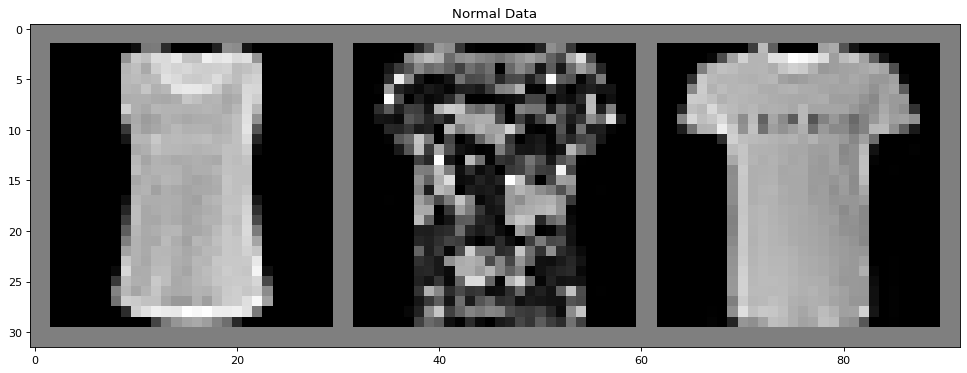

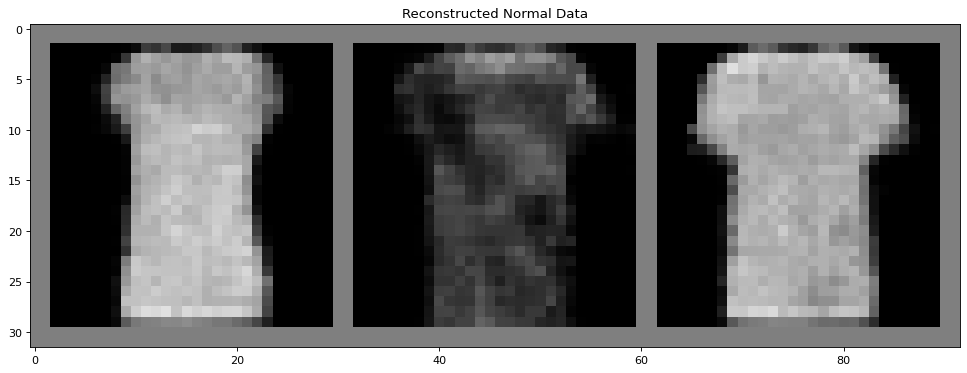

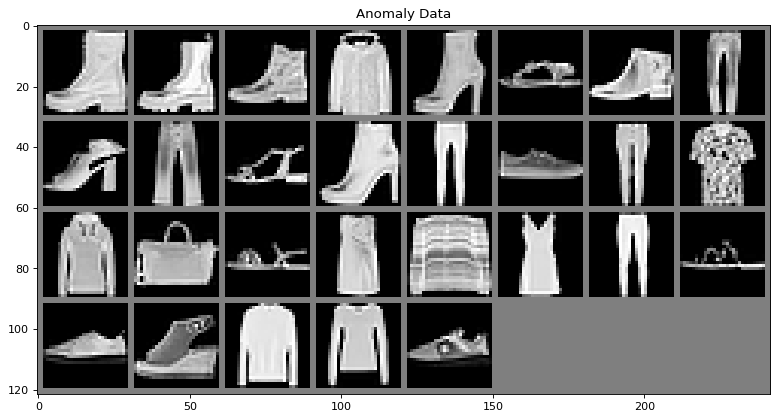

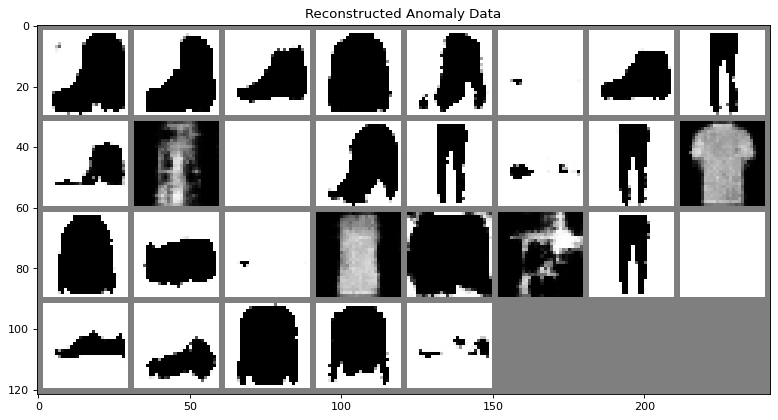

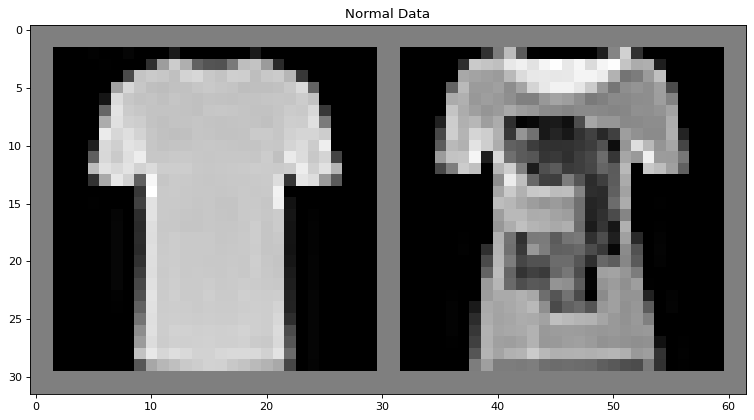

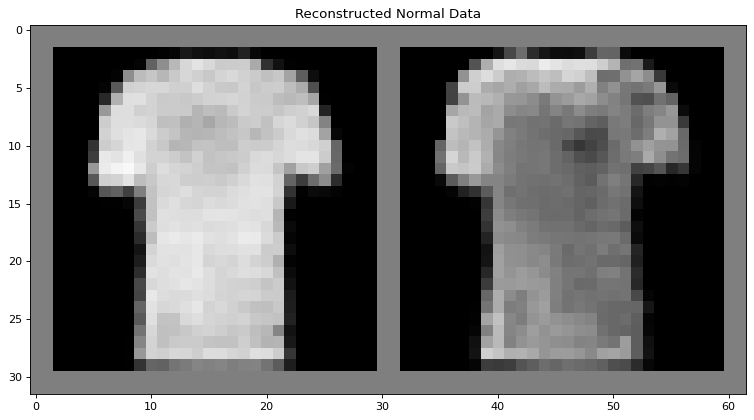

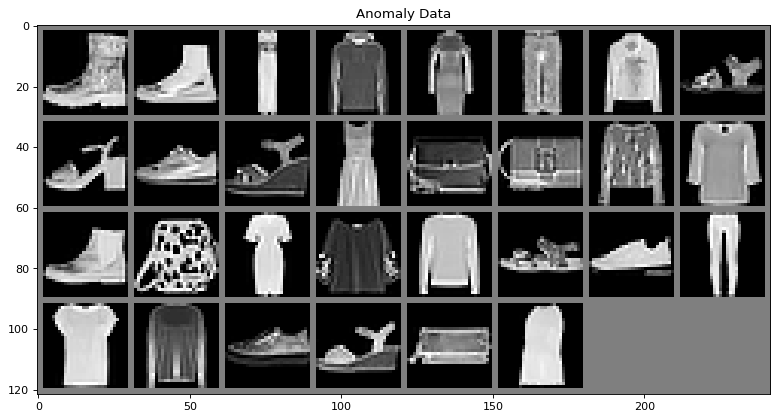

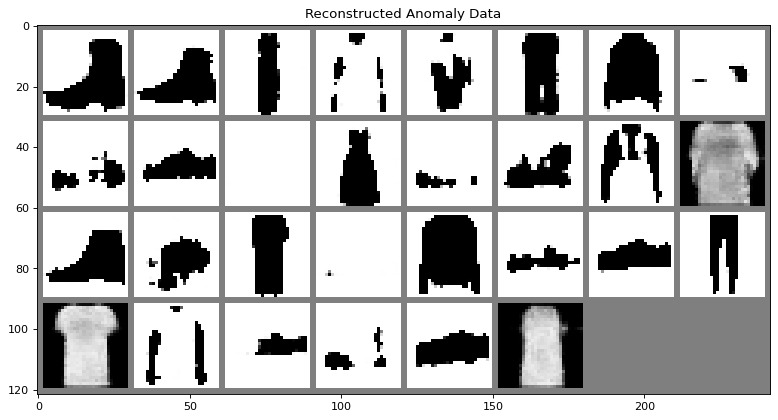

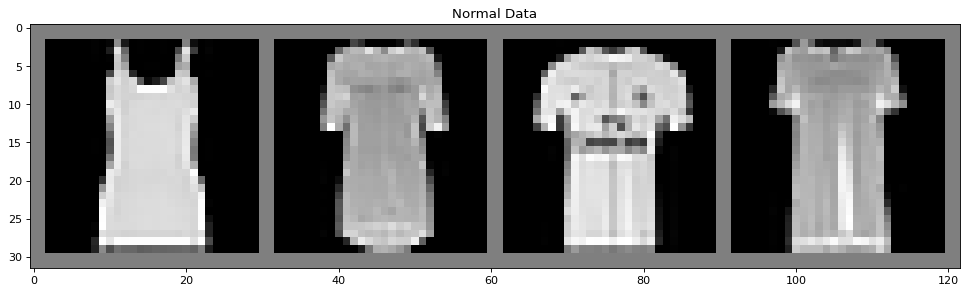

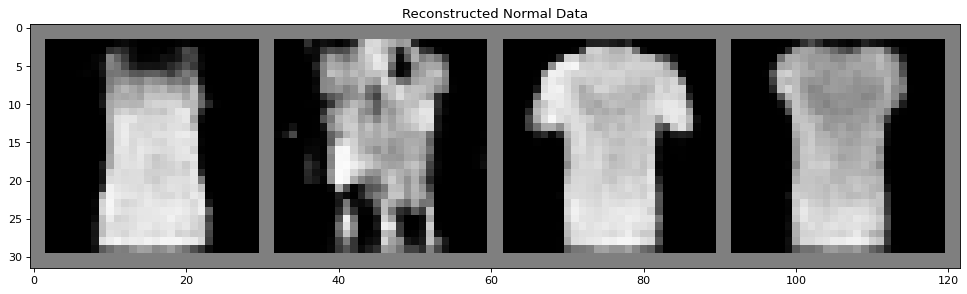

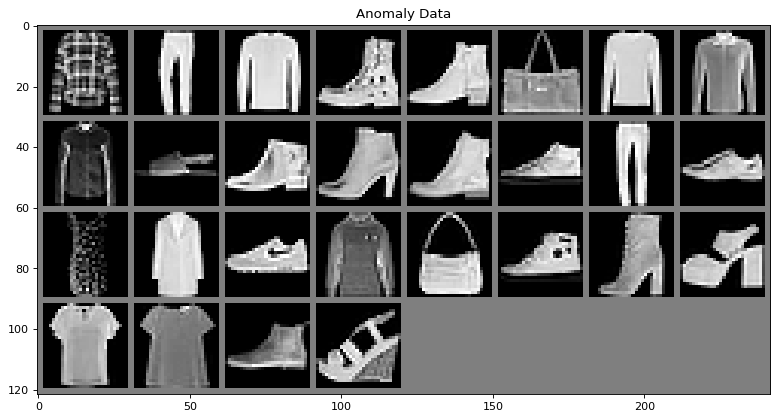

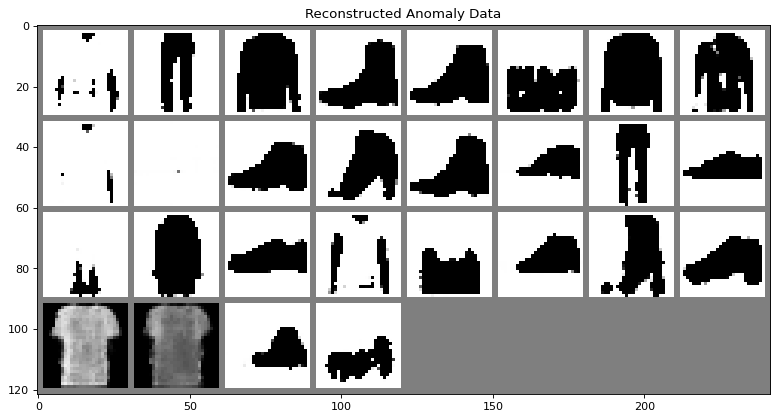

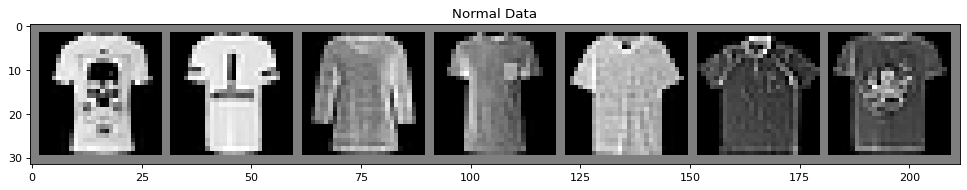

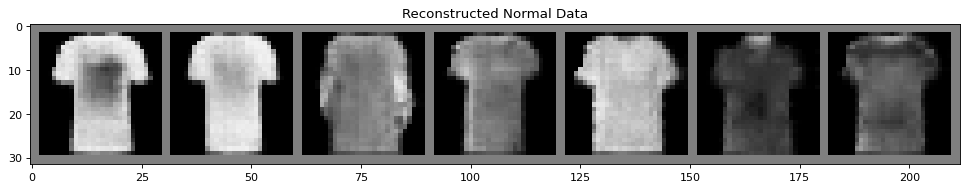

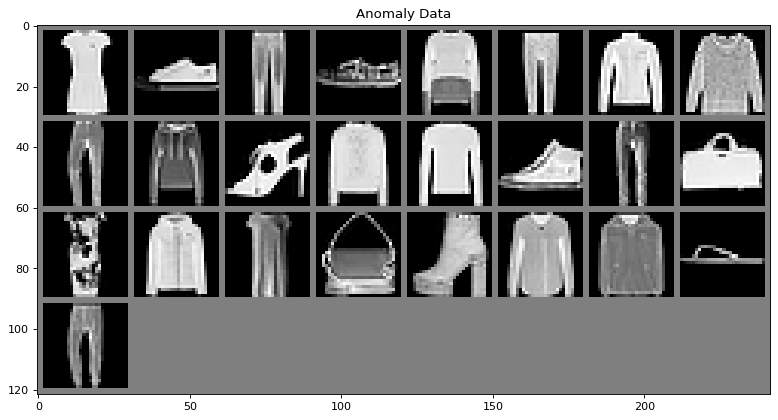

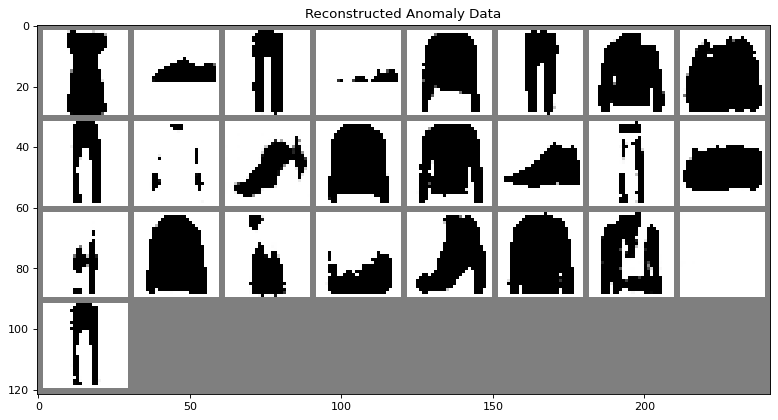

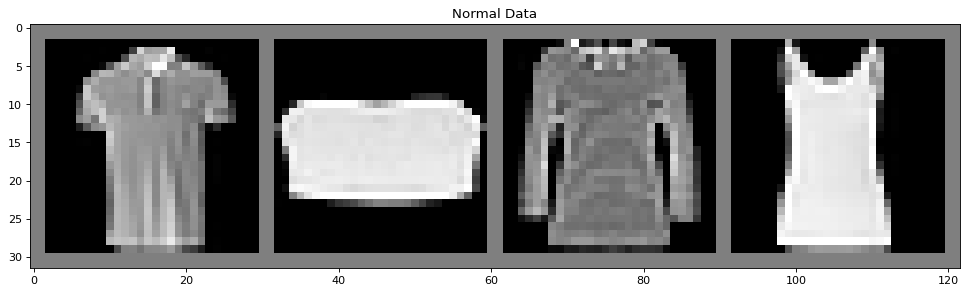

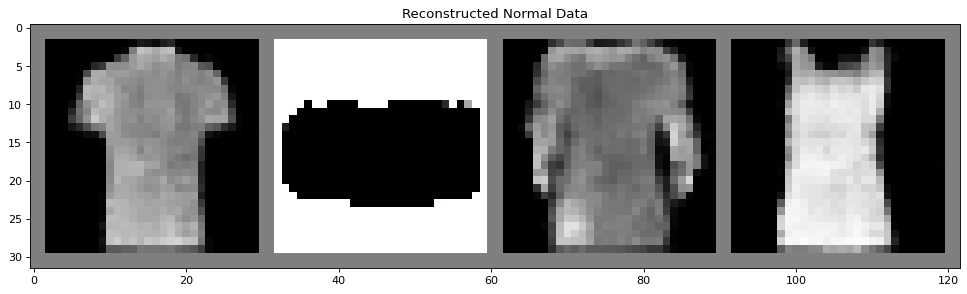

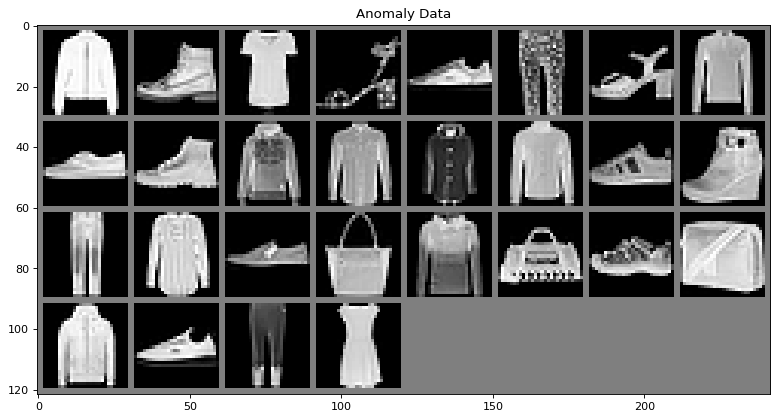

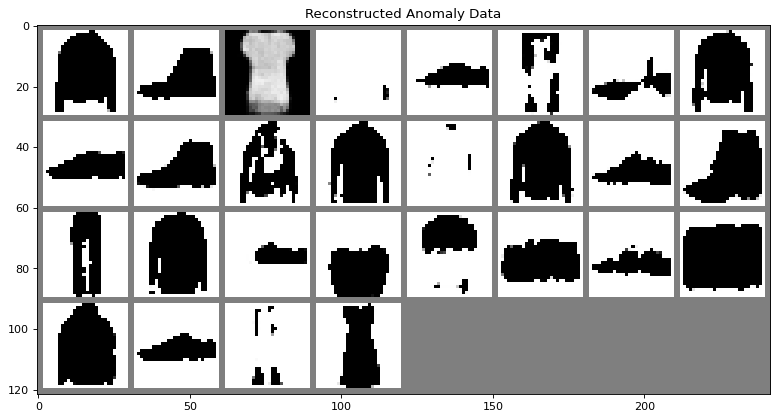

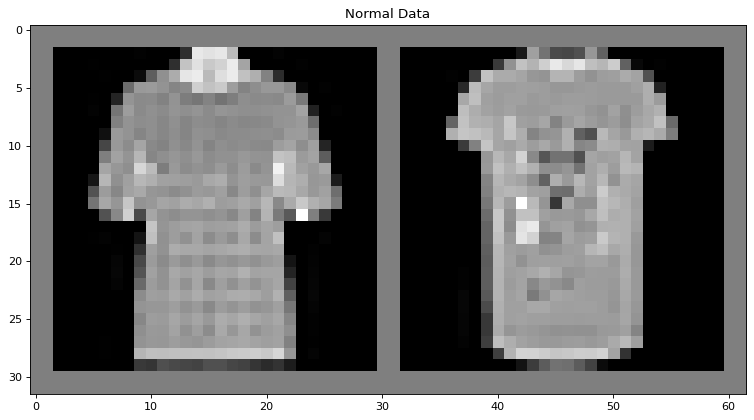

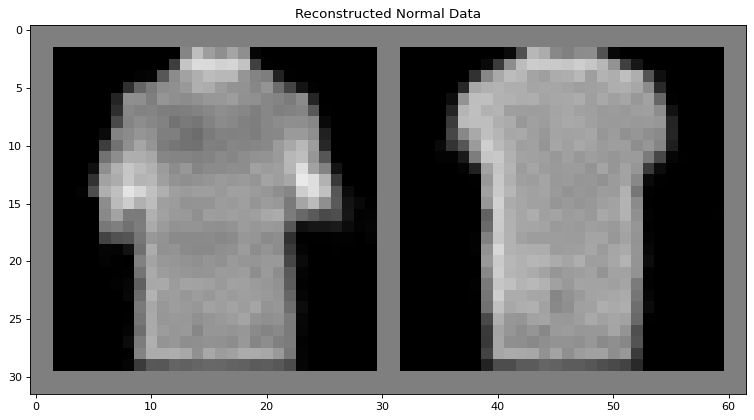

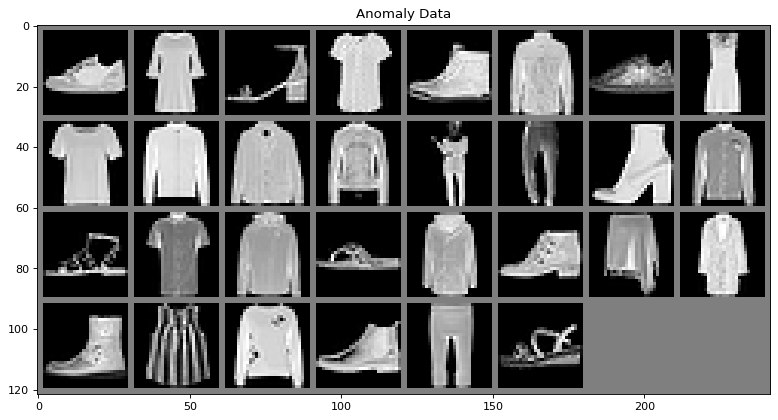

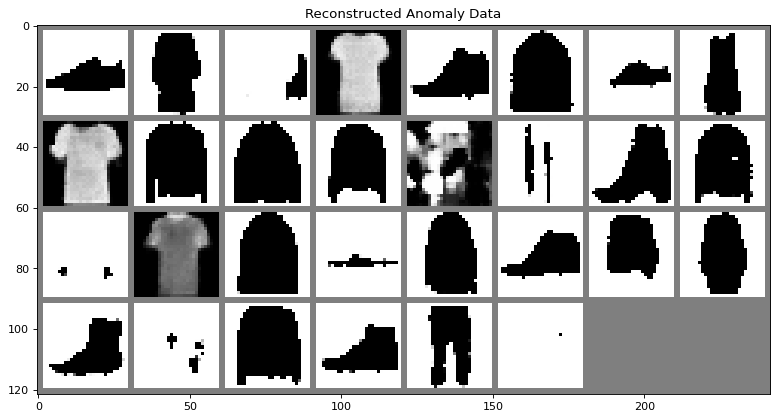

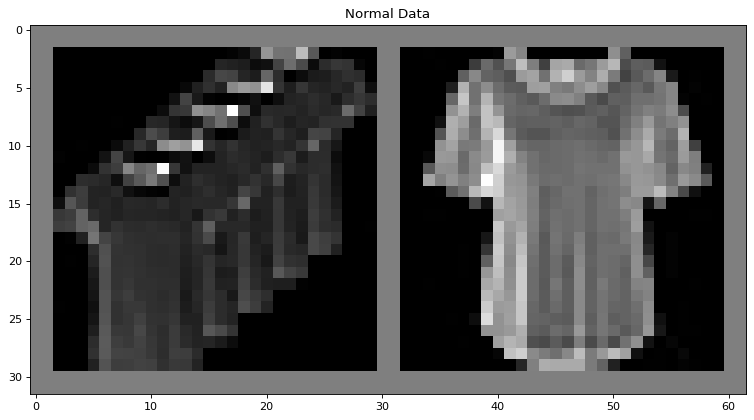

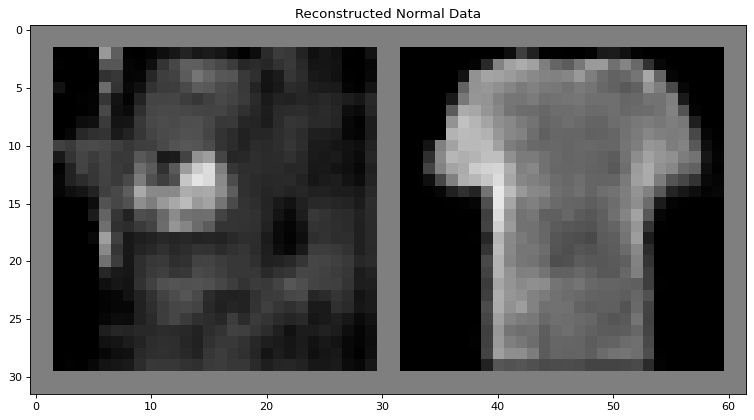

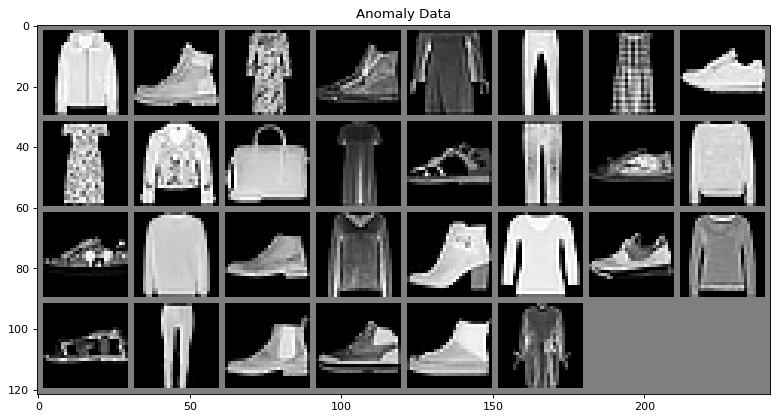

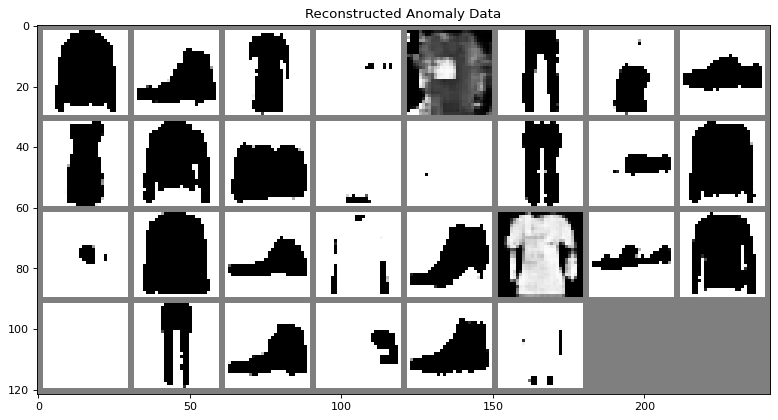

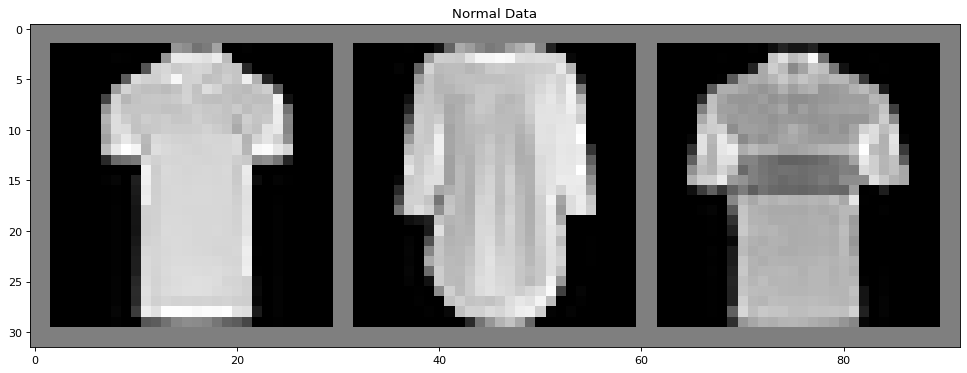

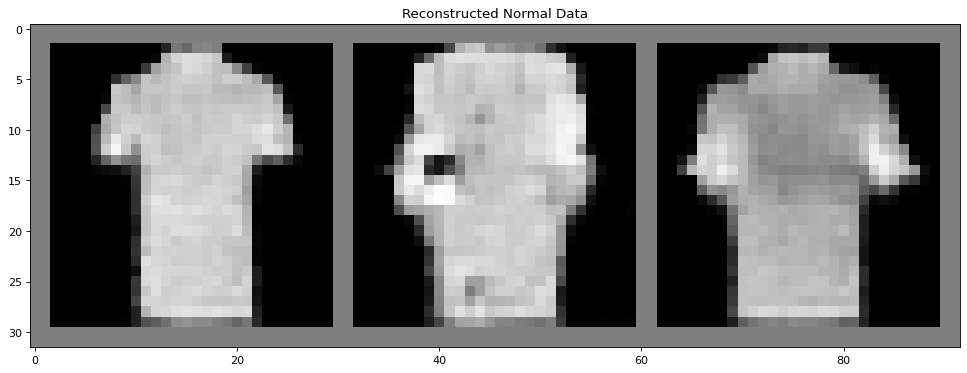

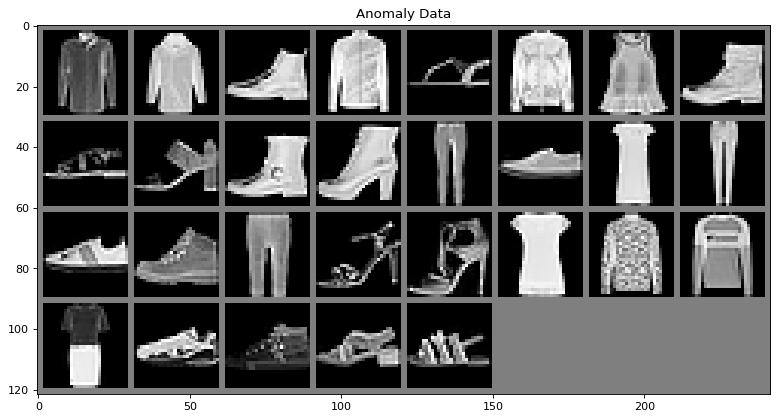

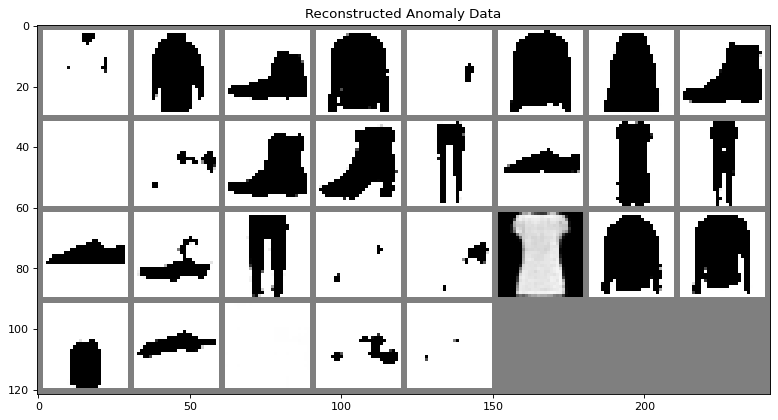

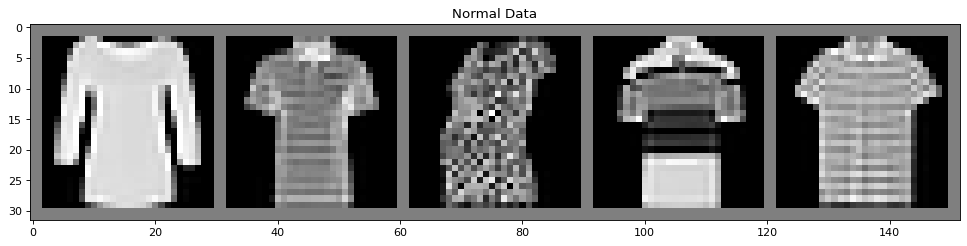

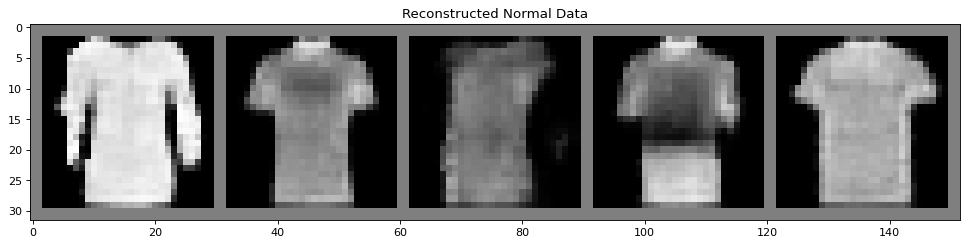

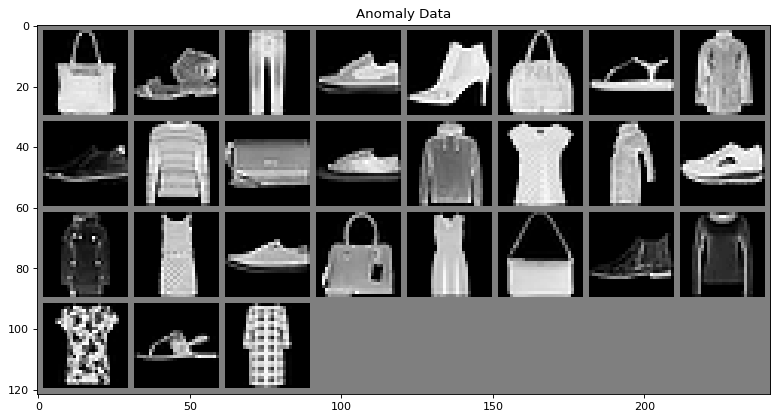

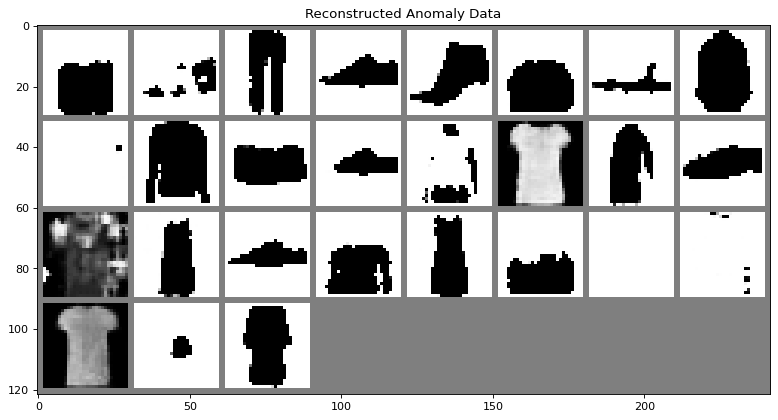

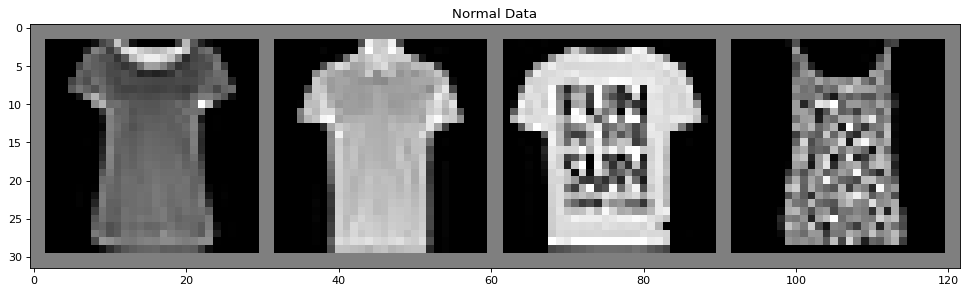

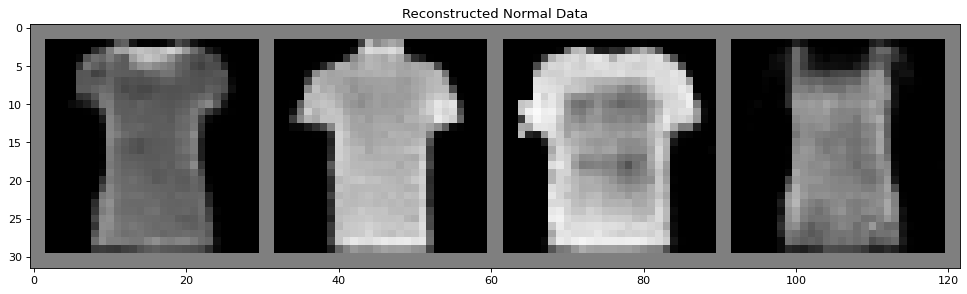

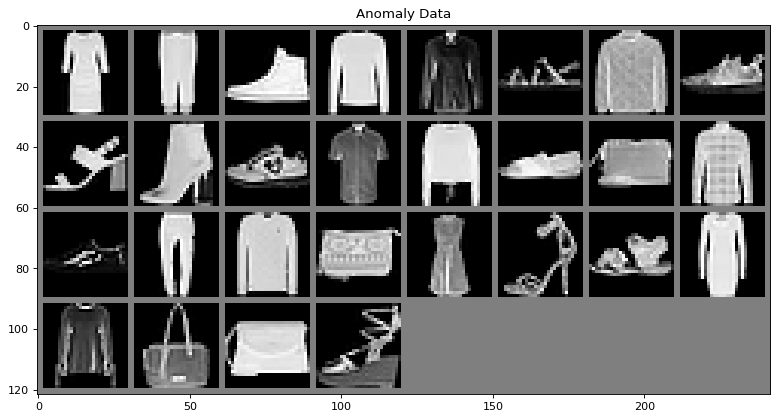

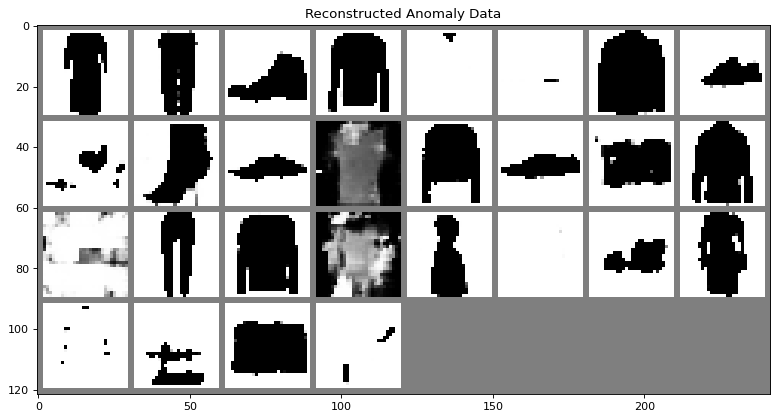

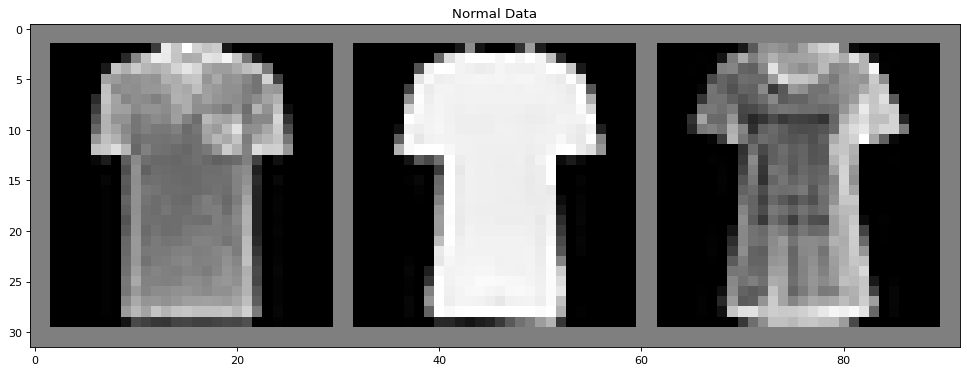

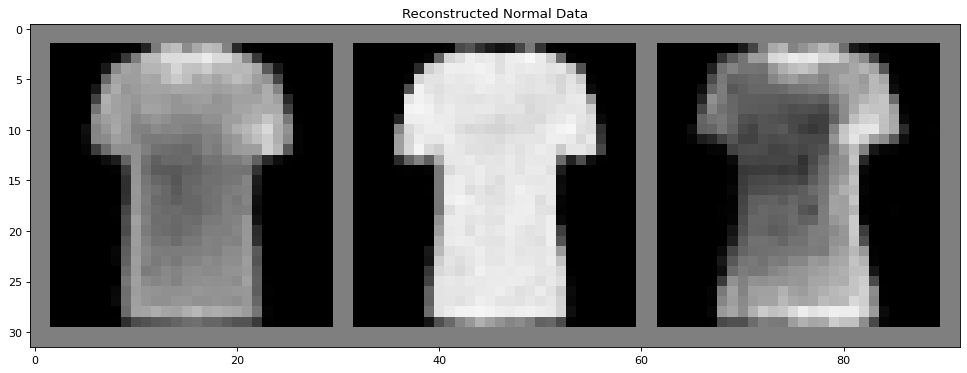

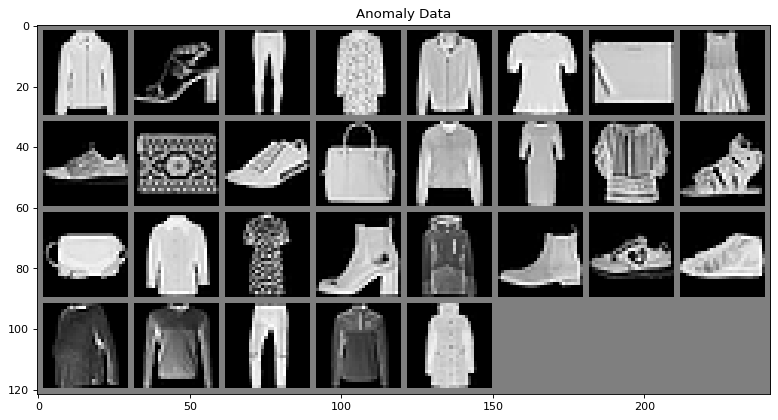

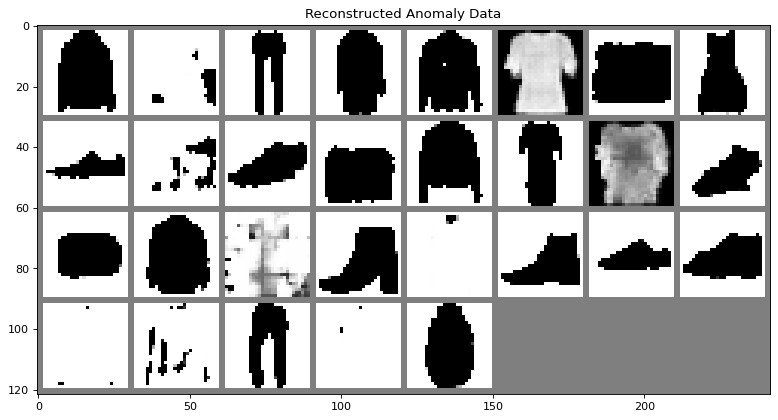

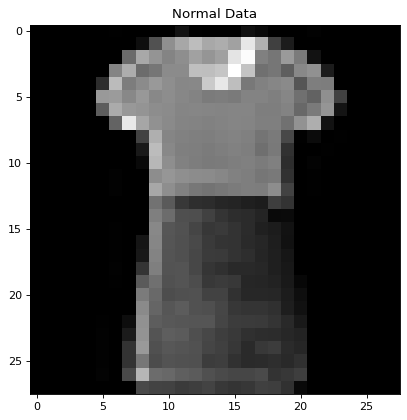

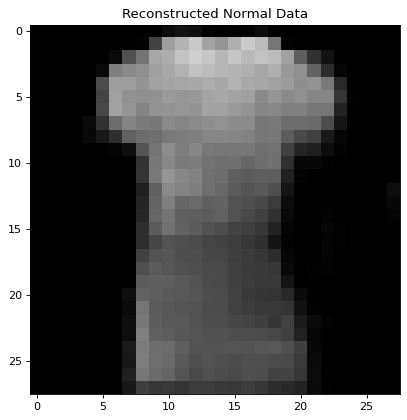

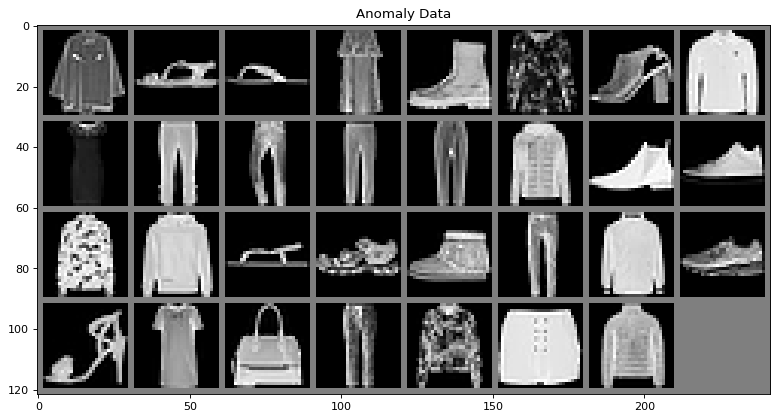

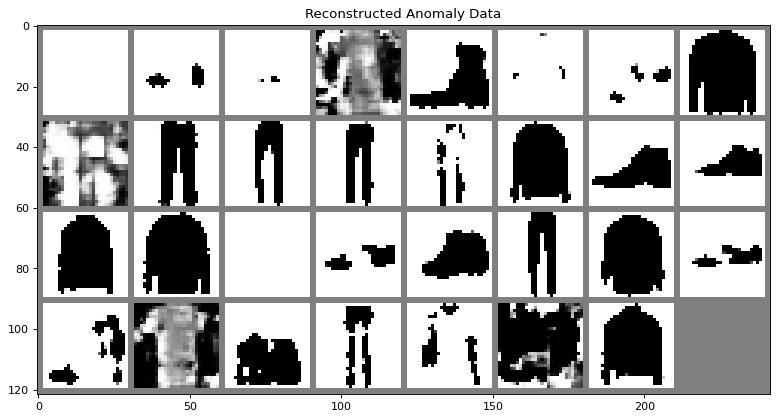

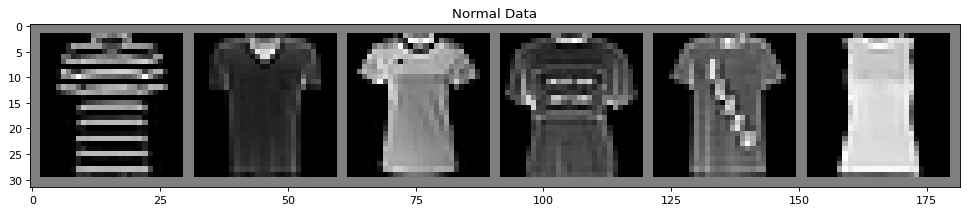

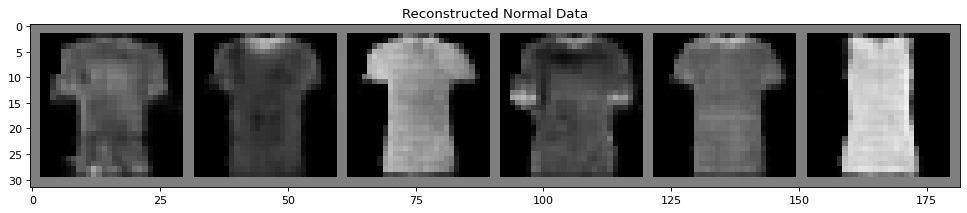

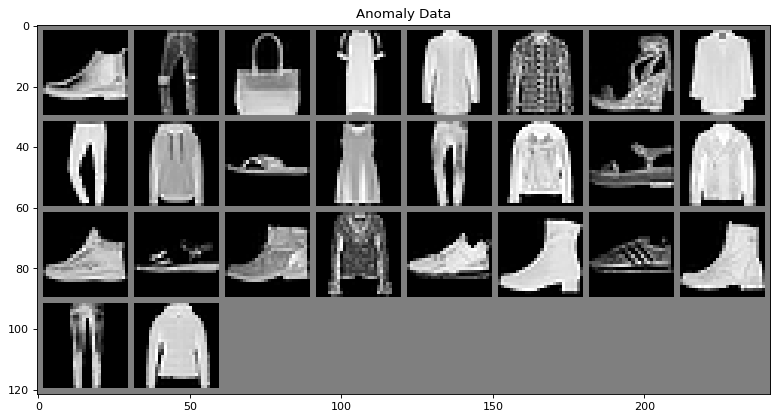

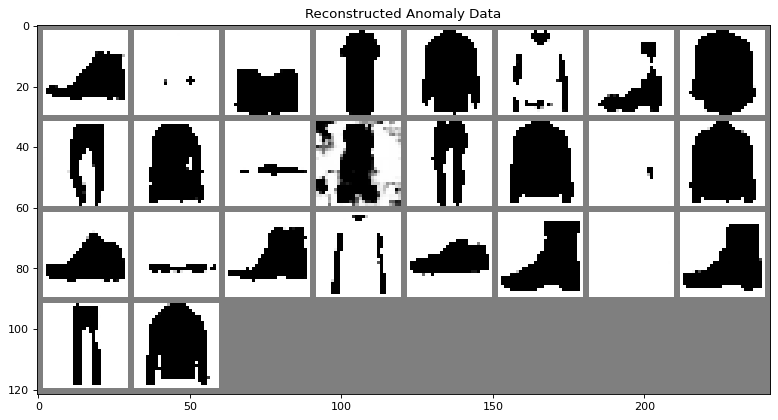

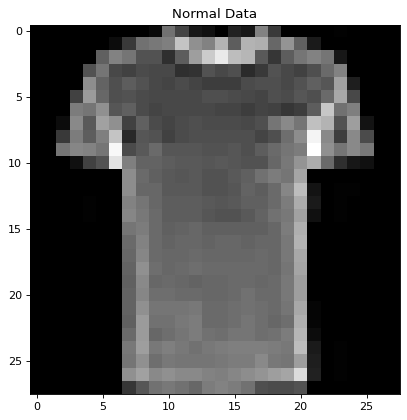

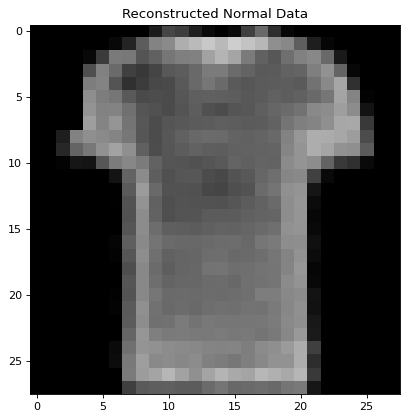

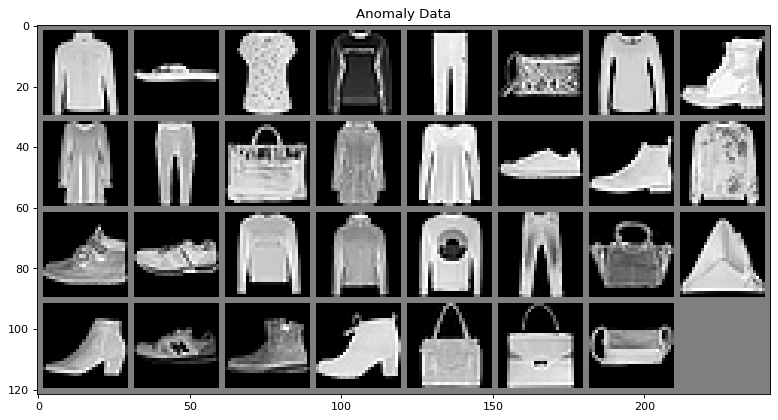

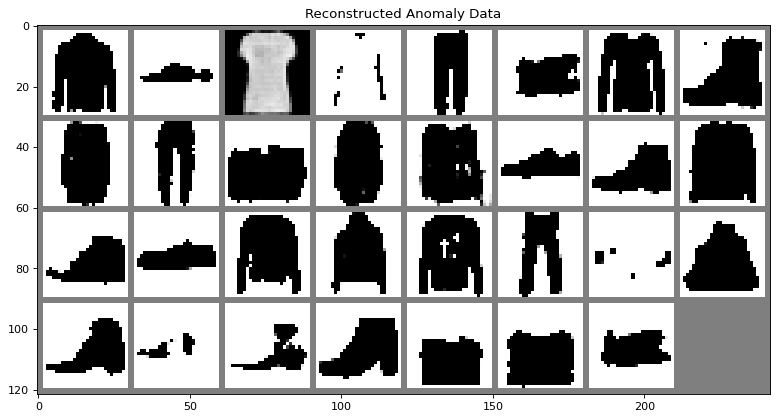

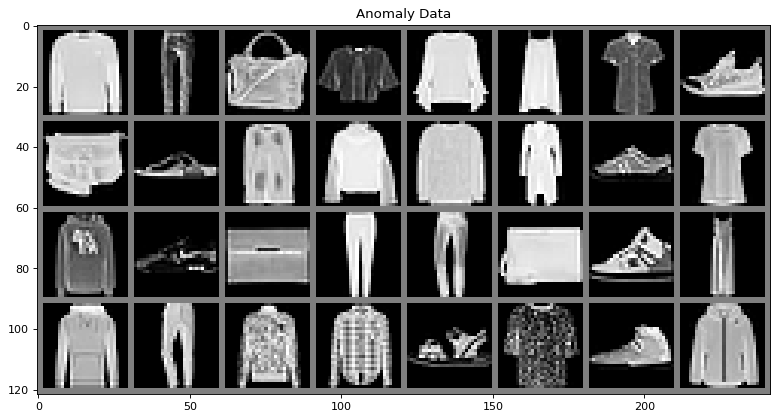

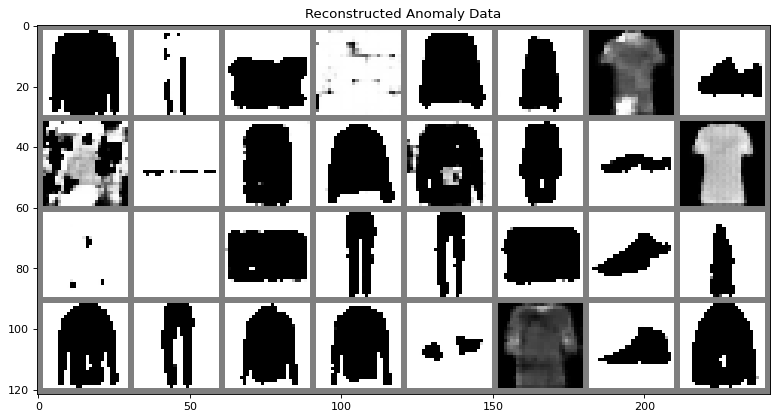

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [13]:


trainer.fit(model, train_loader)


In [14]:
test_dataset = datasets.FashionMNIST(root="dataset/",train= False, transform=transforms, download=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [15]:
L =trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('Normal_loss', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('Anomaly_loss', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Anomaly_loss        │    0.8365650177001953     │
│        Normal_loss        │    0.05300179868936539    │
└───────────────────────────┴───────────────────────────┘

In [16]:
L

[{'Normal_loss': 0.05300179868936539, 'Anomaly_loss': 0.8365650177001953}]

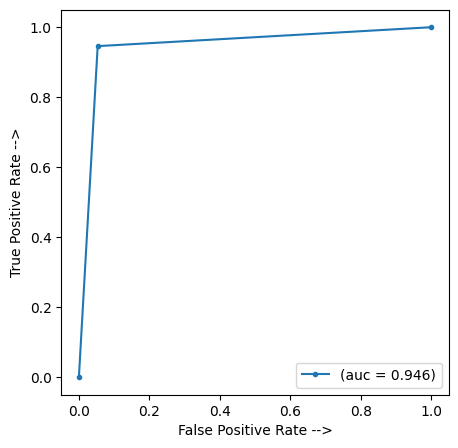

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, marker='.', label='(auc = %0.3f)' % auc)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

In [19]:
!pip install plot_metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


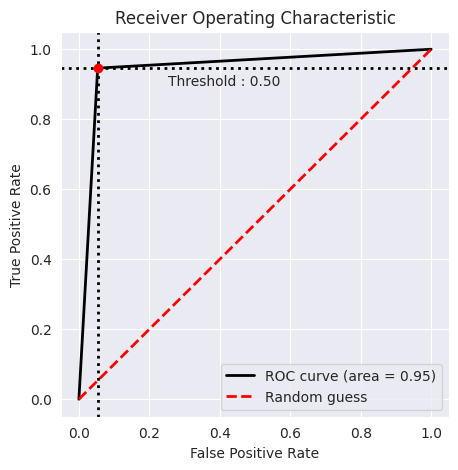

In [20]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()
